In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn.datasets as d
import sklearn.model_selection as ms
import sklearn.metrics as mt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydot  #graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image #IPython의 display와 관련된 Pulbic API


# 글씨체 보이기
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. 데이터 전처리

In [2]:
# 데이터 불러오기
data = pd.read_csv("departure_data.csv", encoding='euc-kr')
df = pd.DataFrame(data)

In [3]:
# 취소 데이터 확인하기
df.loc[(df['현황'] == '취소') & (df['사유'] == '태풍'), '현황'] = '기상 취소'
cancel_rows = df[df['현황'] == '취소']
reason_counts = cancel_rows['사유'].value_counts()

In [4]:
# 지연 데이터 확인하기
delay_rows = df[df['현황'] == '지연']
reason_counts = cancel_rows['사유'].value_counts()

In [5]:
df['최저운고'].fillna(0, inplace=True)
df['강수량(mm)'].fillna(0, inplace=True)
df['현황'].fillna('출발', inplace=True)

# 기상 취소, 기상 지연의 이유가 아닌 행들을 삭제하는 코드
# 취소에 사유가 없는 열 삭제
df = df[(df['현황'] != '취소')]
# 지연에 사유가 없는 열 삭제
df = df[(df['현황'] != '지연') | (df['사유'].notna())]
# 회항, 기상회항 삭제
df = df[(df['현황'] != '회항')]
df = df[(df['현황'] != '기상 회항')]

In [6]:
df

,날짜,항공사,편명,출발공항코드,출발공항명,도착공항코드,도착공항명,계획시간,예상시간,출발시간,시간,온도,시정,전운량,최저운고,풍속,강수량(mm),구분,현황,사유
0,2017-01-01 00:00:00,아시아나항공,OZ286,ICN,인천,SFO,샌프란시스코,00:05,23:40,00:07,00:00,0.2,450,2,30.0,2,0.0,화물,출발,NaN
1,2017-01-01 00:00:00,에미레이트항공,EK323,ICN,인천,DXB,두바이,00:10,23:50,00:40,00:00,0.2,450,2,30.0,2,0.0,여객,출발,NaN
2,2017-01-01 00:00:00,아시아나항공,OZ2041,ICN,인천,LAX,로스앤젤레스,00:10,23:50,00:28,00:00,0.2,450,2,30.0,2,0.0,여객,출발,NaN
3,2017-01-01 00:00:00,싱가폴항공,SQ007,ICN,인천,SIN,싱가포르,00:25,00:36,00:35,00:00,0.2,450,2,30.0,2,0.0,여객,출발,NaN
4,2017-01-01 00:00:00,터키항공,TK91,ICN,인천,IST,아타튀르크,00:40,00:40,01:01,00:00,0.2,450,2,30.0,2,0.0,여객,출발,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585021,2019-12-31 00:00:00,아시아나항공,OZ286,ICN,인천,SFO,샌프란시스코,23:30,23:30,23:42,23:00,-4.1,1000,8,30.0,3,0.0,화물,출발,NaN
585022,2019-12-31 00:00:00,대한항공,KE319,ICN,인천,CAN,광저우,23:35,23:35,23:33,23:00,-4.1,1000,8,30.0,3,0.0,화물,출발,NaN
585023,2019-12-31 00:00:00,필리핀에어아시아,Z27047,ICN,인천,CEB,세부,23:50,23:50,23:54,23:00,-4.1,1000,8,30.0,3,0.0,여객,출발,NaN
585024,2019-12-31 00:00:00,산동항공,SC4722,ICN,인천,TAO,청도,23:50,23:50,23:56,23:00,-4.1,1000,8,30.0,3,0.0,여객,출발,NaN


### 증폭 전 데이터 분포 시각화 하기

C:\Users\user\AppData\Local\Temp\ipykernel_5524\3651330186.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/Users/user/Documents/DataMining/termproject.png')
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


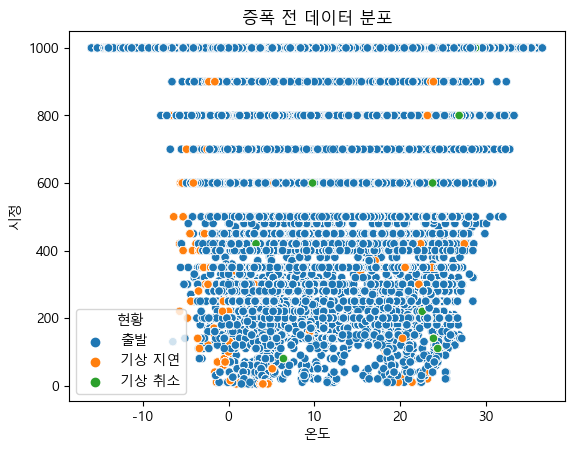

In [6]:
# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf = df[selected]

sns.scatterplot(data=sdf, x=sdf.iloc[:, 0], y=sdf.iloc[:, 1], hue='현황')
plt.title("증폭 전 데이터 분포")
plt.savefig('/Users/user/Documents/DataMining/termproject.png')

In [7]:
X = df[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = df['현황']
from collections import Counter  
counter = Counter(y)
print(counter)

Counter({'출발': 532733, '기상 지연': 4918, '기상 취소': 473})


# 2. SMOTE

In [8]:
# 각 카테고리별 데이터 개수 출력
print("원본 데이터셋의 각 카테고리별 개수:")
print(df['현황'].value_counts())

# 출발 이외의 데이터를 추출
non_departure_data = df[df['현황'] != '출발']

# 출발 데이터만 따로 추출
departure_data = df[df['현황'] == '출발']

# 각 카테고리별 데이터 개수에 맞게 샘플링
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy='auto',random_state=42)

# 데이터 증강
X_sm, y_sm = smt.fit_resample(X,y)

#클래스 수 파악 
from collections import Counter  
counter2 = Counter(y_sm)
print(counter2)

# # dataframe 연결
X_sm = pd.DataFrame(X_sm)
y_sm = pd.DataFrame(y_sm)
smote_data = pd.concat([X_sm, y_sm], axis=1)

# 새로운 데이터셋의 각 카테고리별 개수 출력
print("\n새로운 데이터셋의 각 카테고리별 개수:")
print(smote_data['현황'].value_counts())

원본 데이터셋의 각 카테고리별 개수:
출발       532733
기상 지연      4918
기상 취소       473
Name: 현황, dtype: int64
Counter({'출발': 532733, '기상 지연': 532733, '기상 취소': 532733})

새로운 데이터셋의 각 카테고리별 개수:
출발       532733
기상 지연    532733
기상 취소    532733
Name: 현황, dtype: int64


In [9]:
smote_data

,온도,시정,전운량,최저운고,풍속,강수량(mm),현황
0,0.200000,450,2,30.000000,2,0.0,출발
1,0.200000,450,2,30.000000,2,0.0,출발
2,0.200000,450,2,30.000000,2,0.0,출발
3,0.200000,450,2,30.000000,2,0.0,출발
4,0.200000,450,2,30.000000,2,0.0,출발
...,...,...,...,...,...,...,...
1598194,26.900000,800,8,30.000000,38,0.0,기상 취소
1598195,26.310245,1000,7,40.000000,3,0.0,기상 취소
1598196,3.148633,1000,5,30.000000,11,0.0,기상 취소
1598197,22.010393,1000,7,9.740177,3,0.0,기상 취소


### 증폭 후 데이터 분포 시각화 하기 (SMOTE)

C:\Users\user\AppData\Local\Temp\ipykernel_5524\2049536040.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/Users/user/Documents/DataMining/termproject.png')
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


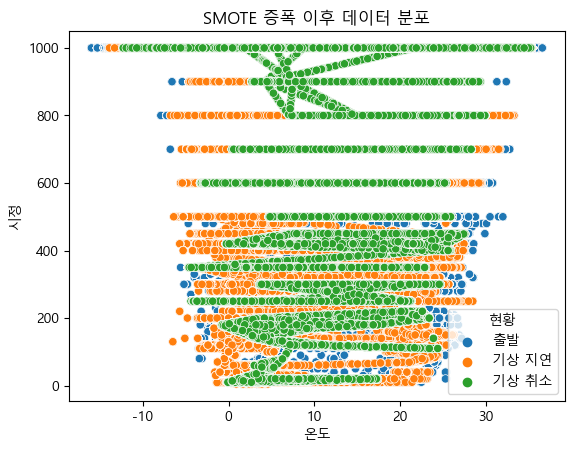

In [10]:
# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf2 = smote_data[selected]

sns.scatterplot(data=sdf2, x=sdf2.iloc[:, 0], y=sdf2.iloc[:, 1], hue='현황')
plt.title("SMOTE 증폭 이후 데이터 분포")
plt.savefig('/Users/user/Documents/DataMining/termproject.png')

# 3. train-test data set 설정

In [11]:
X = smote_data[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = smote_data['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1118739, 6) (479460, 6) (1118739,) (479460,)


# 4. 모델링 - Decision Tree (원본 SMOTE Data)

### Hyper Parameter Tuning - GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [20, 25, 30],
              'min_samples_split': [16, 32, 64],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(dt_clf, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt.fit(X_test, y_test)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
12,30,16,best,0.944590
6,25,16,best,0.940281
14,30,32,best,0.928691
13,30,16,random,0.928361
8,25,32,best,0.925408
0,20,16,best,0.919428
7,25,16,random,0.915509
2,20,32,best,0.909657
16,30,64,best,0.908499
10,25,64,best,0.906413


In [13]:
best_params = {'max_depth' : 30, 'min_samples_split': 16, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=30, min_samples_split=16)

### 교차검증

In [14]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.8466792911231178


### 학습결과평가

In [15]:
#학습결과평가
from sklearn.metrics import classification_report
best_dt.fit(X_test, y_test)
predict_dt = best_dt.predict(X_test)
print(classification_report(y_test, predict_dt, zero_division=0))
accuracy = accuracy_score(y_test, predict_dt)
print("Accuracy of Decision Tree: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.96      0.96      0.96    159922
       기상 취소       0.97      0.98      0.97    159874
          출발       0.97      0.96      0.97    159664

    accuracy                           0.97    479460
   macro avg       0.97      0.97      0.97    479460
weighted avg       0.97      0.97      0.97    479460

Accuracy of Decision Tree:  0.9663079297543069


# 4. 모델링 - Multinomial Logistic Regression (원본 SMOTE Data)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

In [17]:
X = smote_data[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = smote_data['현황']

### Hyper Parameter Tuning - GridSearchCV

In [18]:
# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2']}

# 테스트와 훈련 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr.fit(X_train_scaled, y_train)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr.cv_results_['params'])
result['mean_test_score'] = grid_mlr.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr.best_params_)
print("GridSearchCV Results:\n", result)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
GridSearchCV Results:
         C penalty  mean_test_score
0   0.001      l2         0.598913
3   1.000      l2         0.598816
4  10.000      l2         0.598816
2   0.100      l2         0.598813
1   0.010      l2         0.598810


In [19]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l2')
best_mlr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=1000, multi_class='multinomial',
                   random_state=42, solver='saga')

### 교차검증

In [20]:
# 교차검증
from sklearn.model_selection import cross_val_score, cross_validate

# 교차 검증 수행
scores = cross_val_score(best_mlr, X, y, cv=5)
cv_results = cross_validate(best_mlr, X, y, cv=5)

print('교차검증 평균: ', scores.mean())
pd.DataFrame(cv_results)

교차검증 평균:  0.5840217528706573


,fit_time,score_time,test_score
0,76.712315,0.282501,0.587289
1,77.317707,0.279248,0.594372
2,76.186383,0.281950,0.557865
3,78.311591,0.281195,0.615145
4,76.307780,0.279845,0.565438


### 학습결과평가

In [21]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score
predict_mlr = best_mlr.predict(X_test_scaled)
print(classification_report(y_test, predict_mlr, zero_division=0))
accuracy = accuracy_score(y_test, predict_mlr)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.65      0.64      0.65    159922
       기상 취소       0.57      0.62      0.60    159874
          출발       0.58      0.53      0.55    159664

    accuracy                           0.60    479460
   macro avg       0.60      0.60      0.60    479460
weighted avg       0.60      0.60      0.60    479460

Accuracy of Multinomial Logistic Regression:  0.5992658407374963


# 4. 모델링 - Random Forest (원본 SMOTE Data)

In [22]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mt
from sklearn.metrics import accuracy_score

In [23]:
X = smote_data[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = smote_data['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1118739, 6) (479460, 6) (1118739,) (479460,)


### Hyper Parameter Tuning - GridSearchCV

In [25]:
#하이퍼 파라미터 튜닝(그리드 서치)4

from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rf6 = RandomForestClassifier(random_state=0)

parameters = {'n_estimators': [120, 130, 140],
              'max_depth': [20, 30, 40],
              'min_samples_split': [4, 8]}

grid_rf4 = GridSearchCV(rf6, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )
grid_rf4.fit(X_train, y_train)

result = pd.DataFrame(grid_rf4.cv_results_['params'])
result['mean_test_score'] = grid_rf4.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)



,max_depth,min_samples_split,n_estimators,mean_test_score
10,30,8,130,0.970007
11,30,8,140,0.969995
6,30,4,120,0.969969
7,30,4,130,0.969968
9,30,8,120,0.969957
8,30,4,140,0.969955
17,40,8,140,0.969680
16,40,8,130,0.969669
15,40,8,120,0.969668
13,40,4,130,0.969298


In [26]:
best_params_rf = grid_rf4.best_params_  
print("Best Parameters for Random Forest:", best_params_rf)

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf.fit(X_train, y_train)

# 최적 모델 평가
predict3 = best_rf.predict(X_test)
print("Accuracy of the Best Random Forest model:", accuracy_score(y_test,predict3)) 

Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 130}
Accuracy of the Best Random Forest model: 0.9714533016310015


### 교차검증

In [27]:
#교차검증: 검증데이터셋 나눠서 평가하기 (데이터셋: training, test, validation 으로 나눔)

from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_rf, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_rf, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.8695863305247965


### 학습 결과 평가

In [28]:
predict_test = best_rf.predict(X_test)

from sklearn.metrics import classification_report

print('Test Data:\n', classification_report(y_test, predict_test, zero_division=0))

Test Data:
               precision    recall  f1-score   support

       기상 지연       0.96      0.96      0.96    159922
       기상 취소       0.97      0.98      0.98    159874
          출발       0.98      0.97      0.98    159664

    accuracy                           0.97    479460
   macro avg       0.97      0.97      0.97    479460
weighted avg       0.97      0.97      0.97    479460



### confusion matrix

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

<Axes: >

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

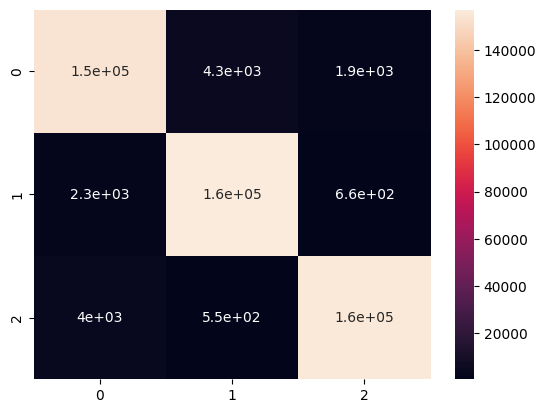

In [29]:
#Heatmap 시각화 (confusion matrix 시각화하기)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict_test)

# 혼동 행렬을 DataFrame으로 변환
cm_df = pd.DataFrame(cm, columns=y.unique(), index=y.unique())

sns.heatmap(cm, annot=True)

## 2만개로 출발 데이터 줄이기

In [12]:
# 데이터프레임에서 "출발"인 값을 가진 행을 추출
selected_data = df[df['현황'] == "출발"]

# 랜덤하게 20,000개 추출
random_selected_data = selected_data.sample(n=20000, random_state=42)

# 지연 데이터 와 취소 데이터 추출하기
delay_data = df[df['현황'] == "기상 지연"]
cancel_data = df[df['현황'] == '기상 취소']

new = [random_selected_data, delay_data, cancel_data]

# 데이터프레임들을 수직 방향으로 합치기
new_df = pd.concat(new, axis=0, ignore_index=True)
new_df
print(new_df['현황'].value_counts())

출발       20000
기상 지연     4918
기상 취소      473
Name: 현황, dtype: int64


In [13]:
new_df

,날짜,항공사,편명,출발공항코드,출발공항명,도착공항코드,도착공항명,계획시간,예상시간,출발시간,시간,온도,시정,전운량,최저운고,풍속,강수량(mm),구분,현황,사유
0,2018-10-09 00:00:00,아시아나항공,OZ122,ICN,인천,NGO,나고야,08:15,08:15,08:25,08:00,13.1,1000,7,120.0,7,0.0,여객,출발,NaN
1,2018-11-10 00:00:00,아시아나항공,OZ309,ICN,인천,WEH,위해,09:00,09:00,09:44,09:00,14.0,350,2,20.0,7,0.0,여객,출발,NaN
2,2017-07-09 00:00:00,독일항공,LH719,ICN,인천,MUC,뮌헨,12:15,12:15,12:36,12:00,28.4,1000,8,10.0,10,0.0,여객,출발,NaN
3,2018-10-01 00:00:00,필리핀항공,PR485,ICN,인천,CEB,세부,08:30,08:30,08:41,08:00,17.2,1000,4,40.0,16,0.0,여객,출발,NaN
4,2018-12-29 00:00:00,제주항공,7C1404,ICN,인천,FUK,후쿠오카,15:30,15:30,15:50,15:00,-4.0,1000,0,0.0,10,0.0,여객,출발,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25386,2019-12-02 00:00:00,진에어,LJ023,ICN,인천,CRK,클라크 국제공항,21:35,:,:,21:00,-1.3,1000,8,30.0,3,0.0,여객,기상 취소,태풍
25387,2019-12-09 00:00:00,산동항공,SC4988,ICN,인천,TNA,지난,22:05,:,:,22:00,8.8,600,8,20.0,16,0.0,여객,기상 취소,시정
25388,2019-12-10 00:00:00,산동항공,SC4988,ICN,인천,TNA,지난,22:05,22:05,:,22:00,8.6,180,6,20.0,11,0.0,여객,기상 취소,시정
25389,2019-12-09 00:00:00,산동항공,SC4722,ICN,인천,TAO,청도,23:50,:,:,23:00,9.8,600,8,20.0,13,0.0,여객,기상 취소,시정


### 2만개 데이터 증폭 전 분포

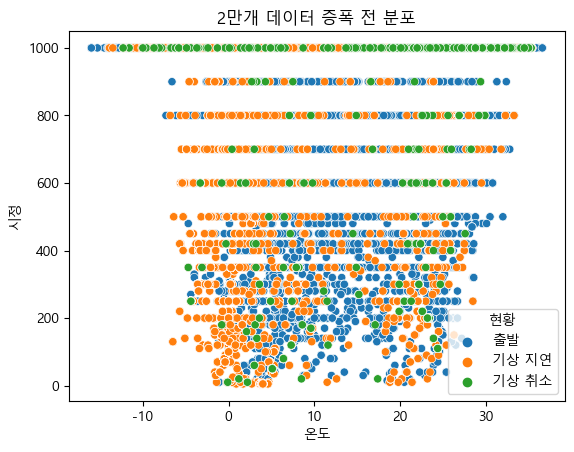

In [14]:
# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf3 = new_df[selected]

sns.scatterplot(data=sdf3, x=sdf3.iloc[:, 0], y=sdf3.iloc[:, 1], hue='현황')
plt.title("2만개 데이터 증폭 전 분포")
plt.savefig('/Users/user/Documents/DataMining/termproject.png')

In [16]:
new_X = new_df[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
new_y = new_df['현황']
from collections import Counter  
counter2 = Counter(new_y)
print(counter2)

Counter({'출발': 20000, '기상 지연': 4918, '기상 취소': 473})


## 2만개 데이터 SMOTE

In [17]:
# 각 카테고리별 데이터 개수 출력
print("원본 데이터셋의 각 카테고리별 개수:")
print(new_df['현황'].value_counts())

# 출발 이외의 데이터를 추출
non_departure_data2 = new_df[new_df['현황'] != '출발']

# 출발 데이터만 따로 추출
departure_data2 = new_df[new_df['현황'] == '출발']

# 각 카테고리별 데이터 개수에 맞게 샘플링
from imblearn.over_sampling import SMOTE
smt2 = SMOTE(sampling_strategy='auto',random_state=42)

# 데이터 증강
X_sm2, y_sm2 = smt2.fit_resample(new_X,new_y)

#클래스 수 파악 
from collections import Counter  
counter2 = Counter(y_sm2)
print(counter2)

# # dataframe 연결
X_sm2 = pd.DataFrame(X_sm2)
y_sm2 = pd.DataFrame(y_sm2)
smote_data2 = pd.concat([X_sm2, y_sm2], axis=1)

# 새로운 데이터셋의 각 카테고리별 개수 출력
print("\n새로운 데이터셋의 각 카테고리별 개수:")
print(smote_data2['현황'].value_counts())

원본 데이터셋의 각 카테고리별 개수:
출발       20000
기상 지연     4918
기상 취소      473
Name: 현황, dtype: int64
Counter({'출발': 20000, '기상 지연': 20000, '기상 취소': 20000})

새로운 데이터셋의 각 카테고리별 개수:
출발       20000
기상 지연    20000
기상 취소    20000
Name: 현황, dtype: int64


In [18]:
smote_data2

,온도,시정,전운량,최저운고,풍속,강수량(mm),현황
0,13.100000,1000,7,120.000000,7,0.000000,출발
1,14.000000,350,2,20.000000,7,0.000000,출발
2,28.400000,1000,8,10.000000,10,0.000000,출발
3,17.200000,1000,4,40.000000,16,0.000000,출발
4,-4.000000,1000,0,0.000000,10,0.000000,출발
...,...,...,...,...,...,...,...
59995,25.795194,1000,7,14.759694,9,0.096122,기상 취소
59996,22.236310,1000,7,30.000000,9,0.000000,기상 취소
59997,23.200000,200,8,5.000000,28,0.000000,기상 취소
59998,35.000000,1000,3,50.000000,17,0.000000,기상 취소


### 2만개 데이터 증폭 후 분포 (SMOTE)

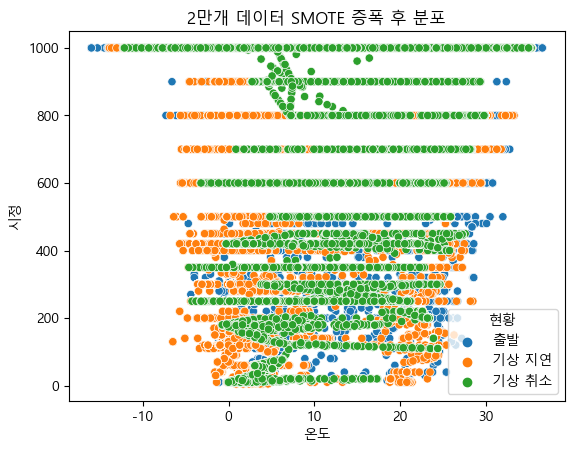

In [19]:
# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf4 = smote_data2[selected]

sns.scatterplot(data=sdf4, x=sdf4.iloc[:, 0], y=sdf4.iloc[:, 1], hue='현황')
plt.title("2만개 데이터 SMOTE 증폭 후 분포")
plt.savefig('/Users/user/Documents/DataMining/termproject.png')

In [20]:
#test, training (7:3 분할)
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X,new_y,test_size = 0.3, random_state = 100)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(17773, 6) (7618, 6) (17773,) (7618,)


# 4. 모델링 - Decision Tree (2만개 SMOTE Data)

### Hyper Parameter Tuning - GridSearchCV

In [40]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf2 = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [10, 15, 20, 25, 30],
              'min_samples_split': [16, 32, 64, 128, 256, 512],
              'splitter': ['best', 'random']}

grid_dt2 = GridSearchCV(dt_clf2, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt2.fit(X_train2, y_train2)

result2 = pd.DataFrame(grid_dt2.cv_results_['params'])
result2['mean_test_score'] = grid_dt2.cv_results_['mean_test_score']
result2.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
0,10,16,best,0.877343
2,10,32,best,0.877061
4,10,64,best,0.875879
13,15,16,random,0.874867
25,20,16,random,0.873685
14,15,32,best,0.873629
16,15,64,best,0.873179
39,25,32,random,0.872897
51,30,32,random,0.872729
12,15,16,best,0.872448


In [41]:
best_params = {'max_depth' : 30, 'min_samples_split': 16, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt2 = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt2.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=30, min_samples_split=16)

### 교차검증

In [42]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt2, new_X, new_y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, new_X, new_y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.8065848138211067


### 학습결과평가

In [43]:
#학습결과평가
from sklearn.metrics import classification_report
predict_dt2 = best_dt.predict(X_test2)
print(classification_report(y_test2, predict_dt2, zero_division=0))
accuracy = accuracy_score(y_test2, predict_dt2)
print("Accuracy of Decision Tree: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.84      0.77      0.80      1488
       기상 취소       0.47      0.52      0.49       137
          출발       0.94      0.96      0.95      5993

    accuracy                           0.91      7618
   macro avg       0.75      0.75      0.75      7618
weighted avg       0.91      0.91      0.91      7618

Accuracy of Decision Tree:  0.9116566027828826


# 4. 모델링 - Multinomial Logistic Regression (2만개 SMOTE Data)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

In [22]:
new_X = smote_data2[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
new_y = smote_data2['현황']

### Hyper Parameter Tuning - GridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV

# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2']}

# 테스트와 훈련 데이터 분할
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X, new_y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr2 = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr2.fit(X_train_scaled2, y_train2)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr2.cv_results_['params'])
result['mean_test_score'] = grid_mlr2.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr2.best_params_)
print("GridSearchCV Results:\n", result)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
GridSearchCV Results:
         C penalty  mean_test_score
0   0.001      l2         0.603429
3   1.000      l2         0.600976
4  10.000      l2         0.600976
2   0.100      l2         0.600881
1   0.010      l2         0.600595


In [27]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr2 = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l2')
best_mlr2.fit(X_train_scaled2, y_train2)

LogisticRegression(C=0.001, max_iter=1000, multi_class='multinomial',
                   random_state=42, solver='saga')

### 교차검증

In [28]:
# 교차검증
from sklearn.model_selection import cross_val_score, cross_validate

# 교차 검증 수행
scores = cross_val_score(best_mlr2, new_X, new_y, cv=5)
cv_results = cross_validate(best_mlr2, new_X, new_y, cv=5)

print('교차검증 평균: ', scores.mean())
pd.DataFrame(cv_results)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

교차검증 평균:  0.5976833333333333


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,fit_time,score_time,test_score
0,21.400406,0.015907,0.617417
1,23.474104,0.019804,0.579667
2,24.938997,0.015675,0.597250
3,28.040231,0.027064,0.598250
4,20.918604,0.026551,0.595833


### 학습결과평가

In [29]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score
predict_mlr2 = best_mlr2.predict(X_test_scaled2)
print(classification_report(y_test2, predict_mlr2, zero_division=0))
accuracy = accuracy_score(y_test2, predict_mlr2)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.64      0.65      0.65      5862
       기상 취소       0.59      0.62      0.60      6134
          출발       0.58      0.54      0.56      6004

    accuracy                           0.60     18000
   macro avg       0.60      0.60      0.60     18000
weighted avg       0.60      0.60      0.60     18000

Accuracy of Multinomial Logistic Regression:  0.6040555555555556


# 4. 모델링 - Random Forest (2만개 SMOTE Data)

In [30]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mt
from sklearn.metrics import accuracy_score

In [31]:
new_X = smote_data2[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
new_y = smote_data2['현황']
#test, training (7:3 분할)
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X,new_y,test_size = 0.3, random_state = 100)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(42000, 6) (18000, 6) (42000,) (18000,)


### Hyper Parameter Tuning - GridSearchCV

In [32]:
#하이퍼 파라미터 튜닝(그리드 서치)5

from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rf7 = RandomForestClassifier(random_state=0)

parameters = {'n_estimators': [120, 130, 140, 150],
              'max_depth': [10, 20, 30, 40],
              'min_samples_split': [4, 8]}

grid_rf5 = GridSearchCV(rf7, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_rf5.fit(X_train2, y_train2)

result = pd.DataFrame(grid_rf5.cv_results_['params'])
result['mean_test_score'] = grid_rf5.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,n_estimators,mean_test_score
16,30,4,120,0.878405
17,30,4,130,0.878381
24,40,4,120,0.878238
27,40,4,150,0.878095
19,30,4,150,0.878048
26,40,4,140,0.878024
18,30,4,140,0.878024
25,40,4,130,0.877857
11,20,4,150,0.876857
8,20,4,120,0.876690


In [33]:
best_params_rf = grid_rf5.best_params_  
print("Best Parameters for Random Forest:", best_params_rf)

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf2 = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf2.fit(X_train2, y_train2)

# 최적 모델 평가
predict3 = best_rf2.predict(X_test2)
print("Accuracy of the Best Random Forest model:", accuracy_score(y_test2,predict3)) 

Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 120}
Accuracy of the Best Random Forest model: 0.8826111111111111


### 교차검증

In [34]:
# #교차검증: 검증데이터셋 나눠서 평가하기 (데이터셋: training, test, validation 으로 나눔)

from sklearn.model_selection import cross_validate

# 여러 평가 지표를 지정
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# cross_validate를 사용하여 교차 검증 수행
cv_results = cross_validate(best_rf2, new_X, new_y, cv=5, scoring=scoring)

# 결과 출력
result_df = pd.DataFrame({
    'Accuracy': cv_results['test_accuracy'],
    'Precision': cv_results['test_precision_macro'],
    'Recall': cv_results['test_recall_macro'],
    'F1': cv_results['test_f1_macro']
})

# 교차검증 평균 출력
print('교차검증 평균 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
    result_df['Accuracy'].mean(),
    result_df['Precision'].mean(),
    result_df['Recall'].mean(),
    result_df['F1'].mean()
))


교차검증 평균 - Accuracy: 0.8882, Precision: 0.8895, Recall: 0.8882, F1: 0.8882


### 학습결과평가

In [35]:
from sklearn.metrics import classification_report

print('Test Data:\n', classification_report(y_test2, predict3, zero_division=0))

Test Data:
               precision    recall  f1-score   support

       기상 지연       0.88      0.86      0.87      5862
       기상 취소       0.92      0.92      0.92      6134
          출발       0.84      0.87      0.86      6004

    accuracy                           0.88     18000
   macro avg       0.88      0.88      0.88     18000
weighted avg       0.88      0.88      0.88     18000

